In [101]:
# Optional for clear plotting on Macs
# %config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

warnings.filterwarnings("ignore")

if not sys.warnoptions:

    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"



In [102]:
# Load libraries
import pandas as pd
from scipy import stats
from plotnine import *
import dame_flame
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path



In [103]:
# Find path
PARENT = "uds-2022-ids-701-team-10"
listing_path = Path(PARENT).parent / "../20_intermediate_files"


In [104]:
# Load dataset
listings2 = pd.read_csv(listing_path/ "final_listings.csv")
listings2 = listings2.drop(columns=["Unnamed: 0"])
listings = listings2.copy()


In [105]:
# T-test on annual revenue across groups
superhosts = listings[listings["host_is_superhost"] == 1]
regularhosts = listings[listings["host_is_superhost"] == 0]
print(superhosts["hotel_room_revenue"].mean() - regularhosts["hotel_room_revenue"].mean())
print(stats.ttest_ind(superhosts["hotel_room_revenue"], regularhosts["hotel_room_revenue"]))


19293.448432430858
Ttest_indResult(statistic=5.464259815709479, pvalue=4.736902751231608e-08)


In [106]:
len(superhosts)

5599

In [107]:
len(regularhosts)

6985

In [108]:
print(superhosts["number_of_reviews_ltm"].mean() - regularhosts["number_of_reviews_ltm"].mean())
print(stats.ttest_ind(superhosts["number_of_reviews_ltm"], regularhosts["number_of_reviews_ltm"]))

13.325647116094325
Ttest_indResult(statistic=41.66237233587012, pvalue=0.0)


<font color="darkgreen">

From the statistically significant p-value in T-test, it seems that there is a negative effect of superhosts on the annual revenue. We will now rum DAME in order to reduce the bias that may have introduced by confounding variables. 


In [109]:
# Check distribution
print(superhosts.shape)
print(regularhosts.shape)


(5599, 24)
(6985, 24)


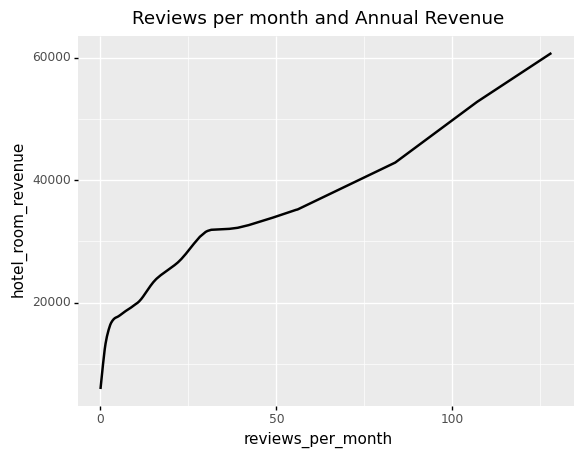

<ggplot: (8761045900400)>

In [110]:
# Check relationship
p = ggplot(listings, aes(x="reviews_per_month", y="hotel_room_revenue")) + geom_smooth(
    method="lowess"
)
p + labs(title="Reviews per month and Annual Revenue")



In [111]:
# Discretize continous variables
listings["bedrooms"] = pd.qcut(listings.bedrooms, 2, labels=False)

listings["host_acceptance_rate"] = pd.qcut(
    listings.host_acceptance_rate, 3, labels=False
)

listings["accommodates"] = listings["accommodates"].astype(int)
listings["accommodates"] = pd.qcut(listings.accommodates, 2, labels=False)

listings["bathrooms_text"] = round(listings["bathrooms_text"].astype(float), 1)
listings["bathrooms_text"] = pd.qcut(listings.bathrooms_text, 2, labels=False)

listings["beds"] = pd.qcut(listings.beds, 2, labels=False)

listings["number_of_reviews_ltm"] = listings["number_of_reviews_ltm"].astype(int)
listings["number_of_reviews_ltm"] = pd.qcut(listings.number_of_reviews_ltm, 5, labels=False)

listings["review_scores_rating"] = listings["review_scores_rating"].astype(int)
listings["review_scores_rating"] = pd.qcut(
    listings.review_scores_rating, 2, labels=False
)

listings["reviews_per_month"] = listings["reviews_per_month"].astype(int)
listings["reviews_per_month"] = pd.qcut(listings.reviews_per_month, 2, labels=False)

listings["other_amenities"] = pd.qcut(listings.other_amenities, 2, labels=False)

listings["host_experience"] = listings["host_experience"].astype(int)
listings["host_experience"] = pd.qcut(listings.host_experience, 2, labels=False)

listings["host_response_rate"] = np.where(listings.host_response_rate == 100, 1, 0)

listings["room_type"] = listings["room_type"].astype("category")
listings["room_type"] = listings["room_type"].cat.codes


listings["state"] = np.where(listings.state == "Florida", 1, 0)

listings["calculated_host_listings_count"] = round(
    listings["calculated_host_listings_count"].astype(int)
)
listings["calculated_host_listings_count"] = np.where(
    listings["calculated_host_listings_count"] == 1,
    0,
    (
        np.where(
            listings["calculated_host_listings_count"] == 2,
            1,
            np.where(listings["calculated_host_listings_count"] == 3, 2, 3,),
        )
    ),
)



In [112]:
listings.sample(5)


,host_id,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,...,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,hotel_room_revenue,host_experience,total_bookings
5214,52411326,1,0,0,1,0,1,1,2,0,...,4,0,1,1,1,1,0,5850.746269,1,104.477612
12381,422934857,0,0,1,0,0,1,1,0,0,...,0,1,1,0,0,1,0,3626.865672,0,1.492537
4411,37424164,0,0,1,1,1,1,1,0,0,...,4,0,1,0,1,1,0,18729.850746,1,210.447761
11044,338695087,0,1,1,1,0,1,0,2,0,...,0,0,1,1,0,1,0,264.179104,0,4.477612
7000,102837956,1,1,1,2,1,1,1,0,1,...,3,0,1,1,0,1,1,109716.716418,0,37.313433


In [113]:
# Drop unnecessary columns for DAME
listings1 = listings.drop(columns=["host_id", "total_bookings"])


In [114]:
# Check data types 
listings1.dtypes


state                               int64
host_response_time                  int64
host_response_rate                  int64
host_acceptance_rate                int64
host_is_superhost                   int64
host_has_profile_pic                int64
host_identity_verified              int64
room_type                            int8
accommodates                        int64
bathrooms_text                      int64
bedrooms                            int64
beds                                int64
has_availability                    int64
number_of_reviews_ltm               int64
review_scores_rating                int64
instant_bookable                    int64
calculated_host_listings_count      int64
reviews_per_month                   int64
essentials                          int64
other_amenities                     int64
hotel_room_revenue                float64
host_experience                     int64
dtype: object

In [115]:
# Run DAME
model = dame_flame.matching.DAME(
    repeats=False, verbose=3, want_pe=True, early_stop_iterations=14
)
model.fit(
    listings1,
    treatment_column_name="host_is_superhost",
    outcome_column_name="hotel_room_revenue",
)
result = model.predict(listings1)
result


Iteration number:  1
	Number of matched groups formed in total:  829
	Unmatched treated units:  3913 out of a total of  5599 treated units
	Unmatched control units:  5637 out of a total of  6985 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  3034
	Number of matches made so far:  3034
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  829
	Unmatched treated units:  3913 out of a total of  5599 treated units
	Unmatched control units:  5637 out of a total of  6985 control units
	Predictive error of covariates chosen this iteration:  70048652309.33978
	Number of matches made in this iteration:  0
	Number of matches made so far:  3034
	In this iteration, the covariates dropped are:  frozenset({'has_availability'})
Iteration number:  3
	Number of matched groups formed in total:  961
	Unmatched treated units:  3751 out of a total of  5599 treated units
	Unm

,state,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,bedrooms,beds,has_availability,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,host_experience
1,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
7,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,*,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
12525,1.0,0.0,1.0,*,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
12533,0.0,0.0,1.0,2.0,*,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,*,0.0,0.0,1.0,0.0,0.0,0.0
12545,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [116]:
# Check for prediction error
for_pe = pd.DataFrame(
    {"prediction error": model.pe_each_iter, "i": range(2, len(model.pe_each_iter) + 2)}
)
for_pe


,prediction error,i
0,7.004865e+10,2
1,7.004977e+10,3
2,7.005001e+10,4
3,7.005031e+10,5
4,7.005051e+10,6
5,7.005146e+10,7
6,7.005161e+10,8
7,7.005162e+10,9
8,7.005195e+10,10
9,7.005212e+10,11


In [117]:
result.sample(5)


,state,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,bedrooms,beds,has_availability,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,host_experience
7925,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12095,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
10437,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4901,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8949,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [118]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    # assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better


In [119]:
# Add weights and annual revenue
listing_dame = get_dataframe(model, result)
listing_dame.head(5)


,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,...,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,hotel_room_revenue,host_experience,match_group,match_group_size,weights
1,0,0,1,0,1,1,1,2,0,0,...,0,1,0,1,0,0.000000,1,132.0,7.0,1.000000
2,0,1,1,0,0,1,1,0,1,1,...,0,1,0,1,0,0.000000,1,127.0,2.0,0.868852
3,0,1,1,0,1,1,1,2,0,0,...,0,0,0,1,0,2134.328358,1,393.0,4.0,1.000000
6,0,0,1,2,1,1,1,0,1,0,...,1,0,1,1,0,7188.059701,1,743.0,2.0,1.000000
7,0,1,1,0,0,1,1,0,0,0,...,0,0,0,1,0,34701.492537,1,894.0,2.0,0.868852


In [120]:

# Run regression 
print(smf.wls(
    "hotel_room_revenue ~ C(host_is_superhost)",
    listing_dame,
    weights=listing_dame["weights"],
).fit().summary())


                            WLS Regression Results                            
Dep. Variable:     hotel_room_revenue   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.128
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.145
Time:                        20:12:58   Log-Likelihood:                -63977.
No. Observations:                4674   AIC:                         1.280e+05
Df Residuals:                    4672   BIC:                         1.280e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [121]:

# Run regression 
print(smf.wls(
    "hotel_room_revenue ~ C(host_is_superhost) + C(state)",
    listing_dame,
    weights=listing_dame["weights"],
).fit().summary())


                            WLS Regression Results                            
Dep. Variable:     hotel_room_revenue   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.99
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           1.74e-05
Time:                        20:12:59   Log-Likelihood:                -63967.
No. Observations:                4674   AIC:                         1.279e+05
Df Residuals:                    4671   BIC:                         1.280e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [122]:
print("Average Treatment Effect: $", round(dame_flame.utils.post_processing.ATE(matching_object=model), 2))


Average Treatment Effect: $ 5627.65


In [123]:
# Recover original values for continous variables
listing_original = listings2.loc[listing_dame.index]
listing_original["weights"] = listing_dame["weights"]


In [124]:
listing_original

,host_id,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,...,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,hotel_room_revenue,host_experience,total_bookings,weights
1,3041,California,0,100,37,1,1,1,2,1.0,...,4.680,0,2.0,0.350,1,17,0.000000,4828.0,0.000000,1.000000
2,6829,California,1,100,54,0,1,1,0,6.0,...,4.645,0,2.0,1.215,1,22,0.000000,4707.5,0.000000,0.868852
3,7830,California,1,100,71,1,1,1,2,2.0,...,4.870,0,1.0,1.480,1,24,2134.328358,4681.0,16.417910,1.000000
6,11652,California,0,100,100,1,1,1,0,6.0,...,4.950,1,1.0,5.350,1,33,7188.059701,4636.0,64.179104,1.000000
7,11975,California,1,100,80,0,1,1,0,2.0,...,5.000,0,1.0,0.100,1,25,34701.492537,4633.0,4.477612,0.868852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,429378149,Florida,0,100,100,0,1,1,0,10.0,...,5.000,0,1.0,0.610,1,48,3107.462687,57.0,1.492537,0.144809
12525,429641072,Florida,0,100,100,0,1,1,0,5.0,...,5.000,1,1.0,1.000,1,45,1450.746269,55.0,1.492537,0.144809
12533,430595578,California,0,100,100,0,0,1,0,2.0,...,5.000,0,1.0,6.000,0,25,1522.388060,31.0,8.955224,0.868852
12545,431473587,California,0,100,78,0,1,1,0,4.0,...,5.000,0,1.0,1.000,1,53,901.492537,26.0,1.492537,0.434426


In [130]:

# Run regression by controlling for all variables
print(smf.wls(
    "hotel_room_revenue ~ C(host_is_superhost) + C(state) + host_response_time + host_response_rate + host_acceptance_rate + C(host_has_profile_pic)\
        + C(host_identity_verified) + C(room_type) + accommodates + bathrooms_text + bedrooms + beds + C(has_availability) + number_of_reviews_ltm +\
        review_scores_rating +  C(instant_bookable) + calculated_host_listings_count + C(essentials) + other_amenities + \
        host_experience",
    listing_original,
    weights=listing_original["weights"],
).fit().summary())


                            WLS Regression Results                            
Dep. Variable:     hotel_room_revenue   R-squared:                       0.474
Model:                            WLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     209.7
Date:                Thu, 07 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:47:18   Log-Likelihood:                -62476.
No. Observations:                4674   AIC:                         1.250e+05
Df Residuals:                    4653   BIC:                         1.251e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [126]:
# Estimate Conditional effect by Matched Groups
group_size_treated = []
group_size_overall = []
cate_of_group = []

for group in model.units_per_group:
    # find len of just treated units
    df_mmg = listing_original.loc[group]
    treated = df_mmg.loc[df_mmg["host_is_superhost"] == 1]
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model, group[0]))


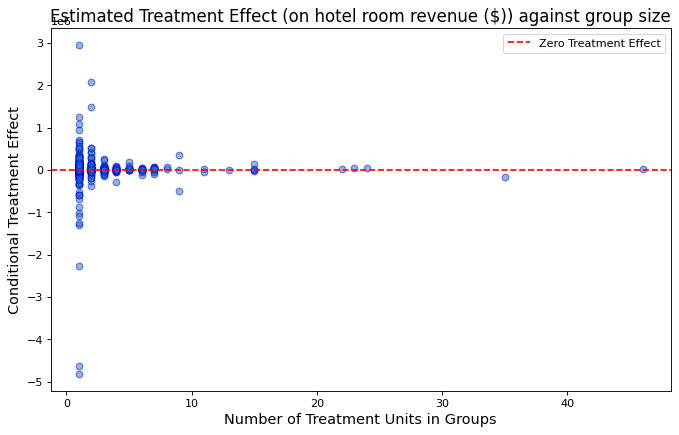

In [127]:
figure(figsize=(10, 6), dpi=80)
plt.scatter(group_size_treated, cate_of_group, alpha=0.5, edgecolors="b")
plt.axhline(y=0.0, color="r", linestyle="--", label="Zero Treatment Effect")
plt.xlabel("Number of Treatment Units in Groups", fontsize=13)
plt.ylabel("Conditional Treatment Effect", fontsize=13)
plt.title(
    "Estimated Treatment Effect (on hotel room revenue ($)) against group size", fontsize=15
)
plt.legend()
plt.show()


<font color="darkgreen">

From the plot above, it seems that there is not much can we infer about the conditional effect of "superhosts" on annual revenue from the dataset. Hence, we cannot conclude if there exists any treatment groups for which the impact of "superhosts" on annual revenue is different than the outcomes for other groups. This observation also leads us to the little average treatment effect we found from the dataset.


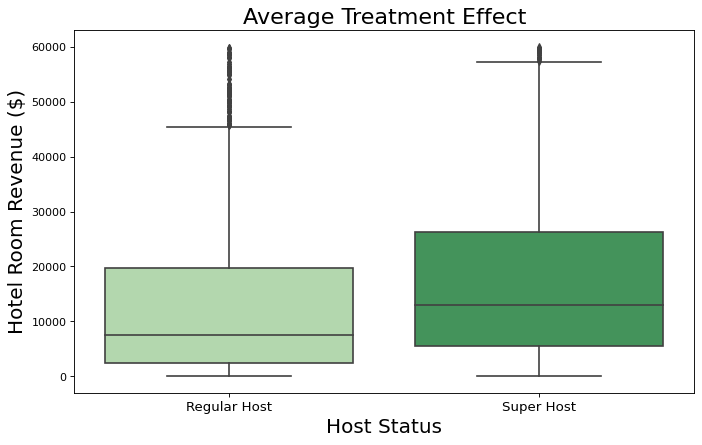

In [128]:
# Visualize box plots for revenue less 2,00,000
ax = figure(figsize=(10, 6), dpi=80)
test = listing_original[listing_original["hotel_room_revenue"] < 60000]
sns.boxplot(x="host_is_superhost", y="hotel_room_revenue", data=test, palette="Greens")

positions = (0, 1)
labels = ("Regular Host", "Super Host")
plt.xticks(positions, labels, fontsize=12)
plt.title("Average Treatment Effect", fontdict={"fontsize": 20})
plt.xlabel("Host Status", fontdict={"fontsize": 18})
plt.ylabel("Hotel Room Revenue ($)", fontdict={"fontsize": 18})
plt.show()


$\textit{Estimated Revenue = Price of Listing }* \textit{ Minimum Average Night Value } * (\textit{ Reviews in the last 12 months } * \frac{\text{100}}{\text{67}})
$

$E(Y_{T=1} | D = 1) - E(Y_{T=0} | D = 0)  = \$ \ 9965.53$